In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
from model_generator_v2 import deep_er_model_generator_v2
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/amazon-google-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-google-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

data['train_2']['price'] = data['train_2']['price'].apply(hp.str_to_num)
data['val_2']['price'] = data['val_2']['price'].apply(hp.str_to_num)
data['test_2']['price'] = data['test_2']['price'].apply(hp.str_to_num)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-google-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model 

In [10]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-google-reduced/glove-300.matrix.npy',
                        text_columns = ['name', 'description'],
                        numeric_columns = ['price'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine','inverse_l1'],
                        text_compositions=['average', 'idf'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True,
                        embedding_trainable=True,
                        batch_norm=True,
                        dropout=0.5)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Number of inputs to dense layer: 16


# Train model 

In [135]:
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 105040 samples, validate on 13130 samples
Epoch 1/1
105040/105040 [==============================] - 4s 41us/step - loss: 0.0224 - acc: 0.9973 - val_loss: 0.0174 - val_acc: 0.9972


# Learning curves

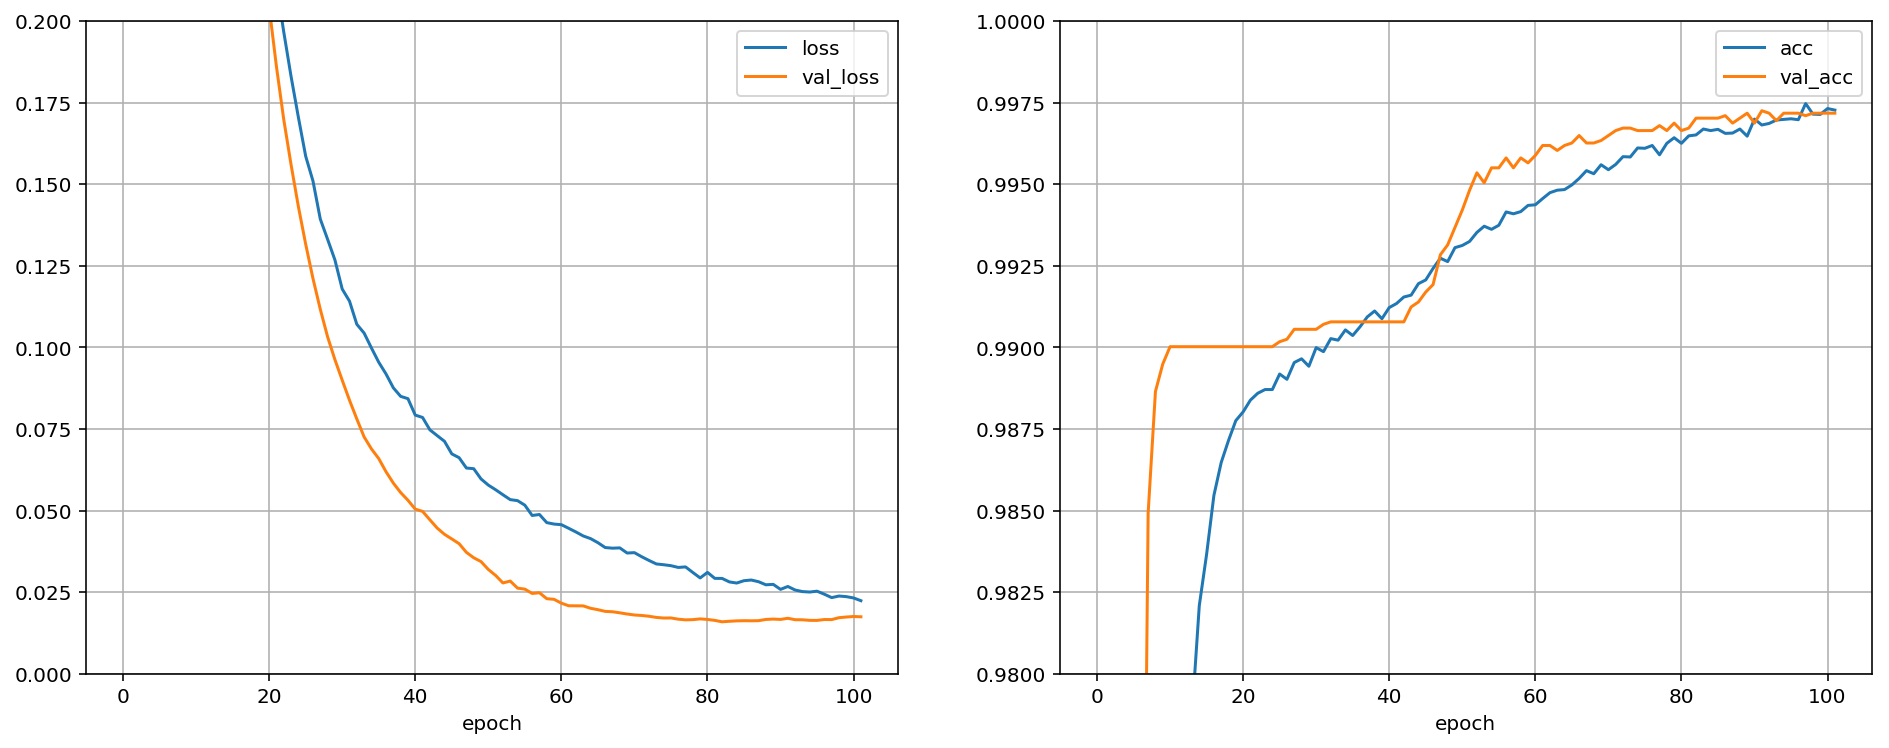

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.2)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.98, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [92]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     12999
          1       0.90      0.79      0.84       131

avg / total       1.00      1.00      1.00     13130

[[12987    12]
 [   27   104]]


In [93]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['name', 'description']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)

In [94]:
df_examine.sample(10)

,id1,name,description,price,id2,name,description,price
368,b000i3g30k,microsoft money home business 2007 win32 eng na mini box us only cd,microsoft corporation microsoft money home business cd mini box microsoft money 2007 home business makes managing business personal finances fast easy automatic precise tools that guide through business taxes inventory tracking online payroll alongside personal credit debt investment taxes so can spend less time finances more time includes everything money 2007 deluxe money 2007 premium make online banking even easier all savings investments credit one place one password which makes keeping tabs spending plus money connects thousands banks updates automatically helping easily stay top improve investment strategy access tips guidance relevant articles highly regarded experts msn new savings spending budget helps plan retirement savings debt repayment as well as monthly its comprehensive budget solution that helps see savings grow debt new spending tracker allows track spending by budget view alongside popular...,139.43,http://www.google.com/base/feeds/snippets/13078719460791292222,microsoft money 2007 home business pc,key features create invoices process payroll free bonus,89.99
7016,b000063v0z,punch punch home design,home renovation takes big leap forward home design punch package that lets draw an imagined future home work altering one investing building materials architects up front divided into series specialized applications this program makes it simple hone room layouts design decks furnishing designs landscape any size shape building when individual pieces are polished home design pulls everything together into big picture unlike many comparable packages this package provides fast streamlined process drawing floor plans moving wall by wall rather than room by room user can lay out everything whether are reconstructing an existing house dreaming big program learning process it still possible end up struggling convince package that an interior room indeed inside house thus deserving carpet rather than lawn but these glitches are rare relatively easy anyone interested having basic plan done both painlessly fast will love inte...,39.99,http://www.google.com/base/feeds/snippets/3325089562849958903,punch 24100 punch home design complete product architectural user complete pc,punch 24100 power tools serious home design plus ultimate deck perfect outdoor addition living powerful programs one that launch same interface including our unique,35.97
10639,b000mfgx7w,microsoft microsoft windows vista business system builders,windows vista business first windows operating system designed specifically meet needs small it helps entire business work more effectively stay connected both out office better protect key,179.99,http://www.google.com/base/feeds/snippets/18416264451031093966,microsoft windows vista business oem,windows vista business operating system designed meet needs business organizations all small businesses windows vista business will help keep pcs running smoothly more,149.99
2749,b000b6n2oe,aspyr media stubbs zombie rebel without pulse dvd,stubbs zombie lets become man whose luck was so bad dying was best thing that ever happened 1933 edward was traveling salesman trying survive great depression when he was murdered buried field fast forward 1959 when billionaire playboy andrew monday builds his own ultramodern city punchbowl where can drink fill unfortunately he built it grave stubbs bringing him back as angry stubbs was loser all his life being zombie gives him power he never had he decides keep eating brains until city his unless andrew monday can stop,9.99,http://www.google.com/base/feeds/snippets/848125606533600340,aspyr stubbs zombie,system requirements operating system os later recommended cpu processor powerpc g4 g5 later cpu speed faster recommended memory 256 mb higher 512 mb recommended hard disk space gb free,35.99
4112,b00002sac9,ibm aap misc parts millie math house ages wi

# Save model and histories 

In [95]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-google-base-1t-num-null-allsim.csv', index=False)
model.save_weights('../data/models/amazon-google-base-1t-num-null-allsim')

# Test model 

In [96]:
model.load_weights('../data/models/amazon-google-base-1t-num-null-allsim')
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99885   0.99931   0.99908     13013
          1    0.91892   0.87179   0.89474       117

avg / total    0.99814   0.99817   0.99815     13130

[[13004     9]
 [   15   102]]
